# Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Convolution Layer

In [2]:
# Conv 3*3
class Conv3x3:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def iterate_regions(self, image):
        h, w = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        h, w = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output

    def backprop(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
        self.filters -= learn_rate * d_L_d_filters
        return None

# Maxpooling Layer

In [3]:
# maxpool
class MaxPool2:
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

# Softmax Activation Function

In [4]:
# softmax
import numpy as np

class Softmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue
            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)

            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            d_L_d_t = gradient * d_out_d_t

            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

        return d_L_d_inputs.reshape(self.last_input_shape)


# Function for Forword Propagation and Backword Propagation

In [5]:
# run

conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.005):
    out, loss, acc = forward(im, label)

    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc


# Dataset

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [7]:
print("Original data set:")
print(f'Size of Train_X {train_images.shape}, size of Train_y {train_labels.shape}')
print(f'Size of Test_X {test_images.shape}, size of Test_y {test_labels.shape}')
print(f'No of classes in training dataset: {len(np.unique(train_labels))}')

Original data set:
Size of Train_X (60000, 28, 28), size of Train_y (60000,)
Size of Test_X (10000, 28, 28), size of Test_y (10000,)
No of classes in training dataset: 10


In [8]:
n = 10000
train_images, train_labels = train_images[:n], train_labels[:n]
test_images, test_labels = test_images[:n//2], test_labels[:n//2]

In [9]:
print('Used Data set:')
print(f'Size of Train_X {train_images.shape}, size of Train_y {train_labels.shape}')
print(f'Size of Test_X {test_images.shape}, size of Test_y {test_labels.shape}')
print(f'No of classes in training dataset: {len(np.unique(train_labels))}')

Used Data set:
Size of Train_X (10000, 28, 28), size of Train_y (10000,)
Size of Test_X (5000, 28, 28), size of Test_y (5000,)
No of classes in training dataset: 10


In [10]:
label_names = [i for i in range(10)]

In [11]:
label_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
for key, value in label_counts.items():
    print('Counts of {} : {}'.format(label_names[key], value))

Counts of 0 : 1001
Counts of 1 : 1127
Counts of 2 : 991
Counts of 3 : 1032
Counts of 4 : 980
Counts of 5 : 863
Counts of 6 : 1014
Counts of 7 : 1070
Counts of 8 : 944
Counts of 9 : 978


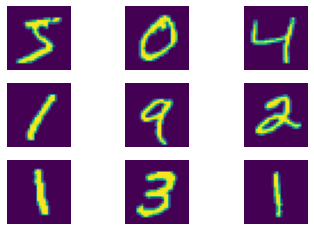

In [12]:
# plot first few images
for i in range(9):
# define subplot
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(train_images[i])
# show the figure
plt.show()

# Training

In [13]:
# Train the CNN for k epochs
acc_g = []
loss_g = []
for epoch in range(4):
    print('--- Epoch %d ---' % (epoch + 1))

    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]

    loss = 0
    num_correct = 0

    corr_pred = 0

    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
              )
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        num_correct += acc
        corr_pred += acc
    loss_g.append(loss/n)
    acc_g.append(corr_pred/n)
    corr_pred = 0


--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.263 | Accuracy: 13%
[Step 200] Past 100 steps: Average Loss 2.191 | Accuracy: 27%
[Step 300] Past 100 steps: Average Loss 1.798 | Accuracy: 45%
[Step 400] Past 100 steps: Average Loss 1.296 | Accuracy: 59%
[Step 500] Past 100 steps: Average Loss 1.046 | Accuracy: 67%
[Step 600] Past 100 steps: Average Loss 0.838 | Accuracy: 75%
[Step 700] Past 100 steps: Average Loss 0.569 | Accuracy: 80%
[Step 800] Past 100 steps: Average Loss 0.731 | Accuracy: 82%
[Step 900] Past 100 steps: Average Loss 0.606 | Accuracy: 77%
[Step 1000] Past 100 steps: Average Loss 0.709 | Accuracy: 78%
[Step 1100] Past 100 steps: Average Loss 0.600 | Accuracy: 80%
[Step 1200] Past 100 steps: Average Loss 0.605 | Accuracy: 83%
[Step 1300] Past 100 steps: Average Loss 0.789 | Accuracy: 81%
[Step 1400] Past 100 steps: Average Loss 0.607 | Accuracy: 84%
[Step 1500] Past 100 steps: Average Loss 0.412 | Accuracy: 90%
[Step 1600] Past 100 steps: Average Loss 0.711 |

[Step 3100] Past 100 steps: Average Loss 0.208 | Accuracy: 94%
[Step 3200] Past 100 steps: Average Loss 0.522 | Accuracy: 87%
[Step 3300] Past 100 steps: Average Loss 0.216 | Accuracy: 94%
[Step 3400] Past 100 steps: Average Loss 0.359 | Accuracy: 91%
[Step 3500] Past 100 steps: Average Loss 0.209 | Accuracy: 95%
[Step 3600] Past 100 steps: Average Loss 0.256 | Accuracy: 93%
[Step 3700] Past 100 steps: Average Loss 0.305 | Accuracy: 92%
[Step 3800] Past 100 steps: Average Loss 0.354 | Accuracy: 89%
[Step 3900] Past 100 steps: Average Loss 0.260 | Accuracy: 93%
[Step 4000] Past 100 steps: Average Loss 0.232 | Accuracy: 93%
[Step 4100] Past 100 steps: Average Loss 0.183 | Accuracy: 97%
[Step 4200] Past 100 steps: Average Loss 0.246 | Accuracy: 93%
[Step 4300] Past 100 steps: Average Loss 0.224 | Accuracy: 96%
[Step 4400] Past 100 steps: Average Loss 0.220 | Accuracy: 93%
[Step 4500] Past 100 steps: Average Loss 0.387 | Accuracy: 85%
[Step 4600] Past 100 steps: Average Loss 0.227 | Accura

[Step 6100] Past 100 steps: Average Loss 0.117 | Accuracy: 97%
[Step 6200] Past 100 steps: Average Loss 0.120 | Accuracy: 98%
[Step 6300] Past 100 steps: Average Loss 0.161 | Accuracy: 95%
[Step 6400] Past 100 steps: Average Loss 0.163 | Accuracy: 94%
[Step 6500] Past 100 steps: Average Loss 0.128 | Accuracy: 98%
[Step 6600] Past 100 steps: Average Loss 0.196 | Accuracy: 94%
[Step 6700] Past 100 steps: Average Loss 0.179 | Accuracy: 95%
[Step 6800] Past 100 steps: Average Loss 0.243 | Accuracy: 91%
[Step 6900] Past 100 steps: Average Loss 0.148 | Accuracy: 95%
[Step 7000] Past 100 steps: Average Loss 0.446 | Accuracy: 93%
[Step 7100] Past 100 steps: Average Loss 0.138 | Accuracy: 96%
[Step 7200] Past 100 steps: Average Loss 0.188 | Accuracy: 94%
[Step 7300] Past 100 steps: Average Loss 0.116 | Accuracy: 96%
[Step 7400] Past 100 steps: Average Loss 0.240 | Accuracy: 96%
[Step 7500] Past 100 steps: Average Loss 0.184 | Accuracy: 94%
[Step 7600] Past 100 steps: Average Loss 0.154 | Accura

[Step 9100] Past 100 steps: Average Loss 0.110 | Accuracy: 96%
[Step 9200] Past 100 steps: Average Loss 0.129 | Accuracy: 95%
[Step 9300] Past 100 steps: Average Loss 0.165 | Accuracy: 96%
[Step 9400] Past 100 steps: Average Loss 0.098 | Accuracy: 97%
[Step 9500] Past 100 steps: Average Loss 0.137 | Accuracy: 94%
[Step 9600] Past 100 steps: Average Loss 0.132 | Accuracy: 94%
[Step 9700] Past 100 steps: Average Loss 0.070 | Accuracy: 99%
[Step 9800] Past 100 steps: Average Loss 0.245 | Accuracy: 94%
[Step 9900] Past 100 steps: Average Loss 0.240 | Accuracy: 93%
[Step 10000] Past 100 steps: Average Loss 0.152 | Accuracy: 93%


In [14]:
print ('Accuracy over epochs: ', acc_g)

Accuracy over epochs:  [0.8579, 0.9274, 0.9437, 0.9538]


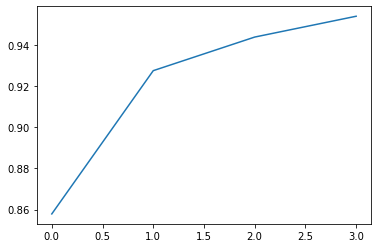

In [15]:
plt.plot(acc_g)
plt.show()

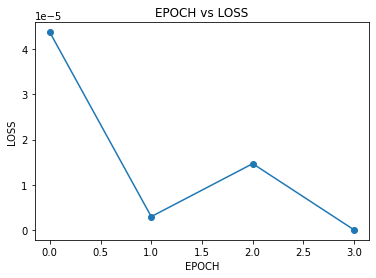

In [16]:
plt.plot(loss_g,'-o')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title('EPOCH vs LOSS')
plt.show()

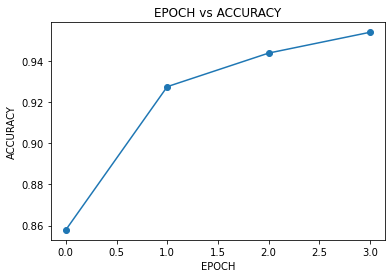

In [17]:
plt.plot(acc_g,'-o')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('EPOCH vs ACCURACY')
plt.show()

# Testing

In [18]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
output = []
for im, label in zip(test_images, test_labels):
    out, l, acc = forward(im, label)
    loss += l
    num_correct += acc
    output.append(np.argmax(out))
num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.22592413209588968
Test Accuracy: 0.928


# Required Libraries for Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix

In [20]:
cm = confusion_matrix(test_labels[:5000], output)
print(cm)

[[451   0   1   0   0   2   3   0   1   2]
 [  0 562   4   0   0   0   3   1   1   0]
 [  1   0 496   4   4   0   3   7  12   3]
 [  3   1  16 457   0  10   2   5   4   2]
 [  0   0   3   1 453   0   4   4  10  25]
 [  7   3   2   6   0 414   4   3  16   1]
 [  9   3   6   0   3  11 425   1   4   0]
 [  0   4  27   5   4   3   0 447   7  15]
 [  5   0   6  11   4   4   0   3 450   6]
 [  2   5   3   2   7   2   0   5   9 485]]


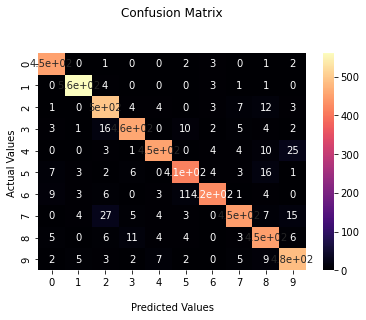

In [25]:
ax = sns.heatmap(cm, annot=True, cmap = plt.cm.magma)
ax.plot(figsize = (50,50))
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()